In [1]:
#DTW calculation

import pandas as pd
import numpy as np
import os
import glob 
import pickle
from math import *
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter
from scipy.fftpack import fft
from dtw import dtw
from numpy import array, zeros, argmin, inf, ndim
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import manhattan_distances
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
# from quatrotate import qv_mult # this routine implements rotation via quaternion multiplication

%matplotlib inline

/home/vicky/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def Amplitude(df, input_features, out_feature):
    df[out_feature] = (df[input_features[0]]**2 + df[input_features[1]]**2  + df[input_features[2]]**2)**(1/2)
  
    

In [3]:
def Yaw_Roll_Pitch(df):
    roll  = []
    pitch = []
    yaw   = []
    for i in range(len(df)):
        x = df['AX'][i]
        y = df['AY'][i]
        z = df['AZ'][i]
        roll1 = atan(y/z)*57.3
        pitch1= atan((-x/(y*y + z*z)**(1/2)))*57.3
        yaw1  = atan((y/((x*x + z*z)**(1/2))))*57.3
        
        roll.append(roll1)
        pitch.append(pitch1)
        yaw.append(yaw1)
    
    df['orientX(Roll)'] = pitch
    df['orientY(pitch)'] = roll
    df['orientZ(yaw)'] = yaw

In [22]:
def GaussianFilter(df, window_length):
#     print(df.columns)
#     for column in df.columns[1:-1]:
#         df[column] = gaussian_filter(df[column], window_length)
    df['AX'] = gaussian_filter(df['AX'], window_length)
    df['AY'] = gaussian_filter(df['AY'], window_length)
    df['AZ'] = gaussian_filter(df['AZ'], window_length)

#     df1['GX'] = gaussian_filter(df['GX'], window_length)
#     df1['GY'] = gaussian_filter(df['GY'], window_length)
#     df1['GZ'] = gaussian_filter(df['GZ'], window_length)

    return df

In [23]:
def data_preprocessing(df):
    #apply gaussian filter with window size 10    
    df = GaussianFilter(df, 30)
    
    #mean feature of 3-axis accelerometer data
    input_features = ['AX', 'AY', 'AZ']
    output_feature = 'mAcc'
    Amplitude(df, input_features, output_feature)
    
    #mean feature of 3-axis gyroscope data
    input_features = ['GX', 'GY', 'GZ']
    output_feature = 'mGyro'
    Amplitude(df, input_features, output_feature)
    
    #Re-Orientation of 3-axis acc. and gyro sensor data
    Yaw_Roll_Pitch(df)
#     qw, qx, qy, qz = getQuat(df)
#     df['quaternionW'] = qw
#     df['quaternionX'] = qx
#     df['quaternionY'] = qy
#     df['quaternionZ'] = qz
#     rotate(df)
    return df

In [24]:
#read csv file and return its data-frame
def read_csv_file(acc, gyro, mode):
    df_gyro = pd.read_csv(gyro, index_col=False)
    df      = pd.read_csv(acc,  index_col=False)
    df.rename(columns = {'X': 'AX', 'Y':'AY', 'Z':'AZ'}, inplace = True)
    df['GX'] = df_gyro['X']
    df['GY'] = df_gyro['Y']
    df['GZ'] = df_gyro['Z']
    
    df['activity'] = mode
    
    return df

In [25]:
def read_files(acc_file, gyro_file, activity):
    df = read_csv_file(acc_file, gyro_file, activity)
    df.reset_index(drop = True , inplace = True)
    if('Milliseconds' in df.columns):
        df = df.drop('Milliseconds', axis=1)
    if('Timestamp' in df.columns):
        df = df.drop('Timestamp', axis=1)
    df = data_preprocessing(df)
    
    return df
    

/home/vicky/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


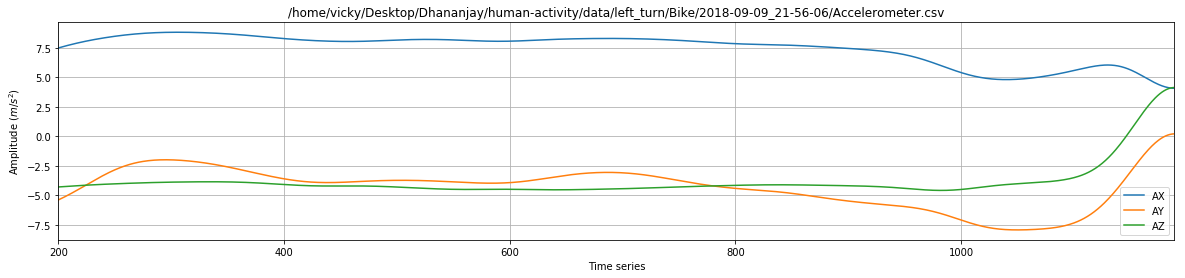

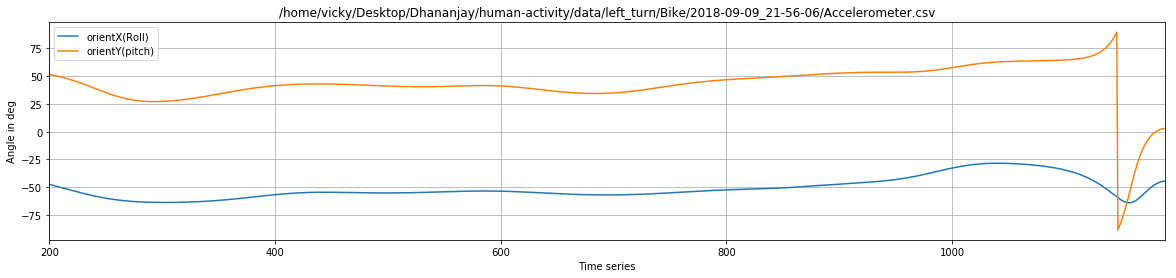

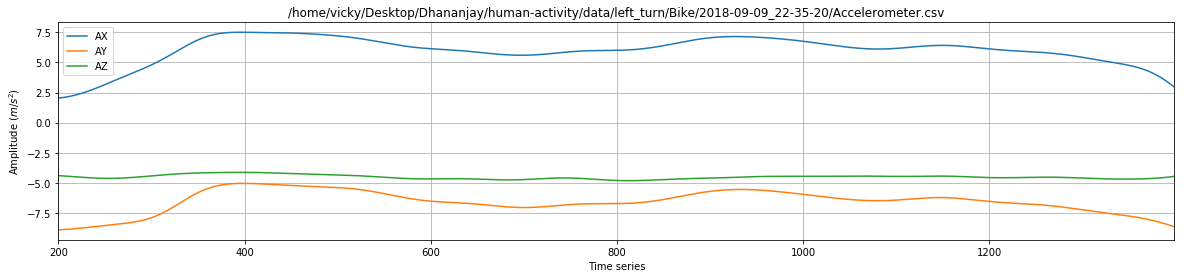

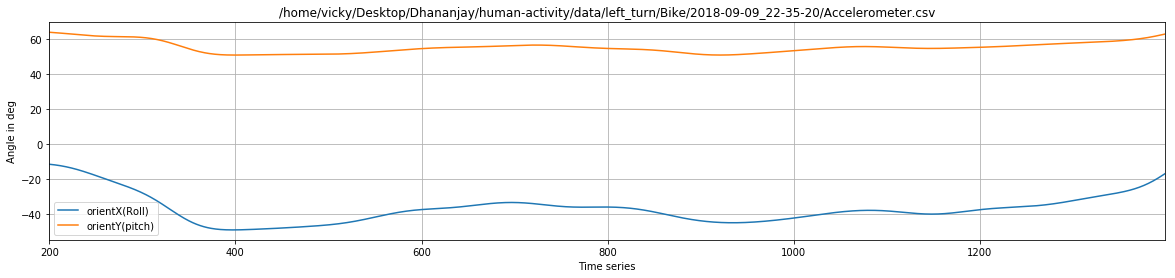

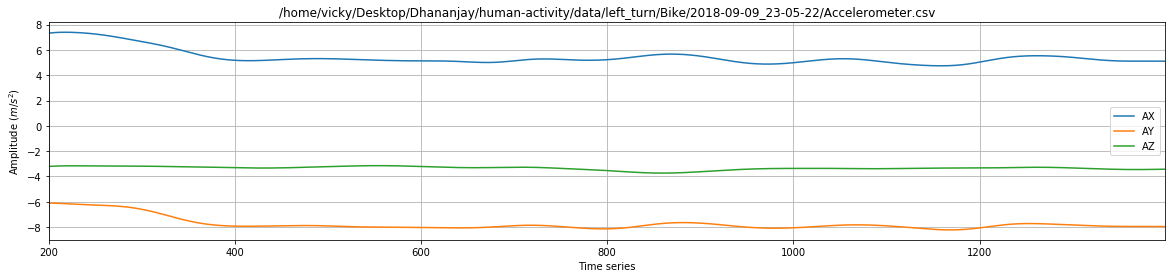

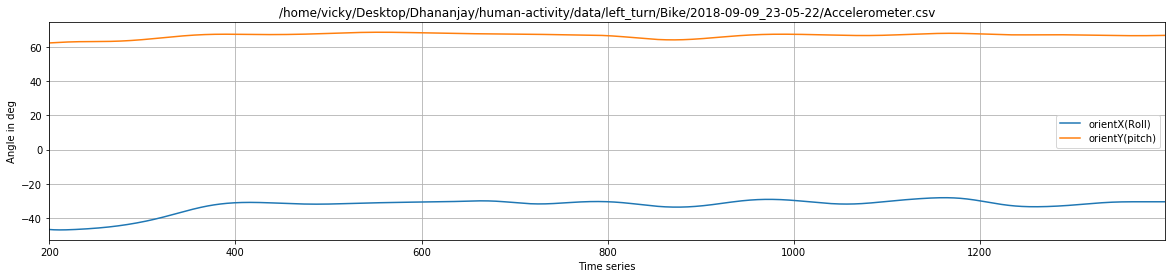

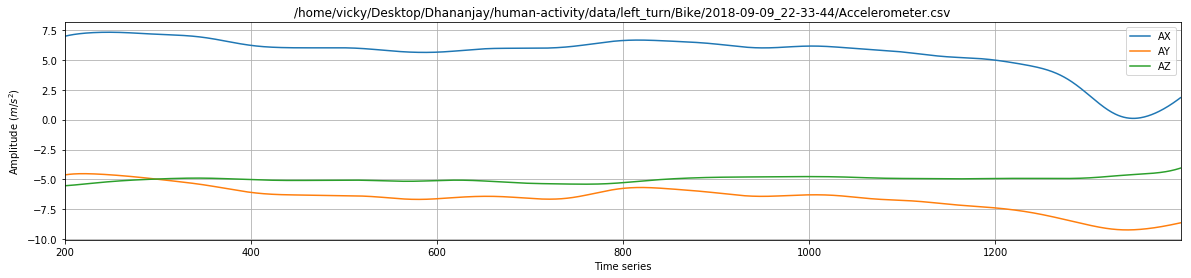

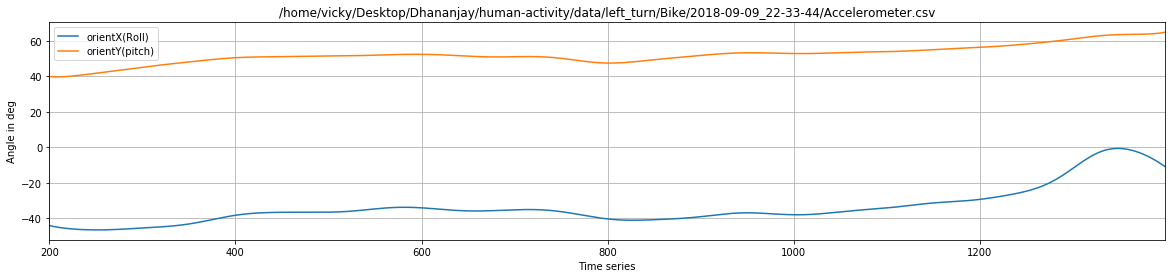

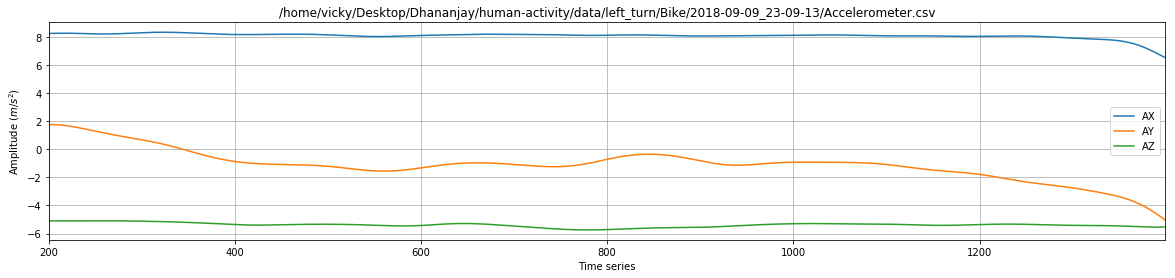

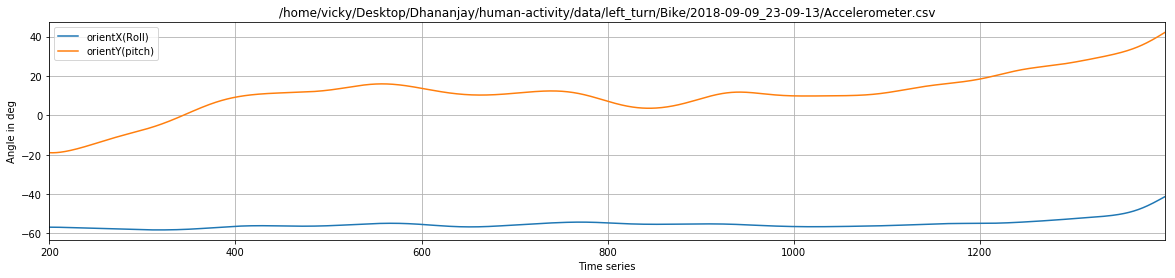

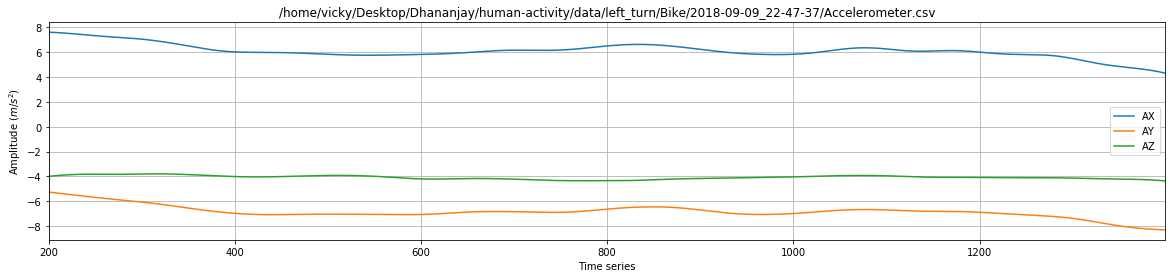

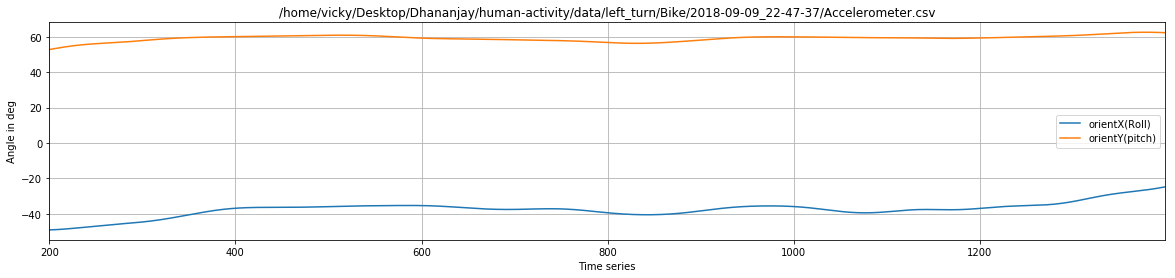

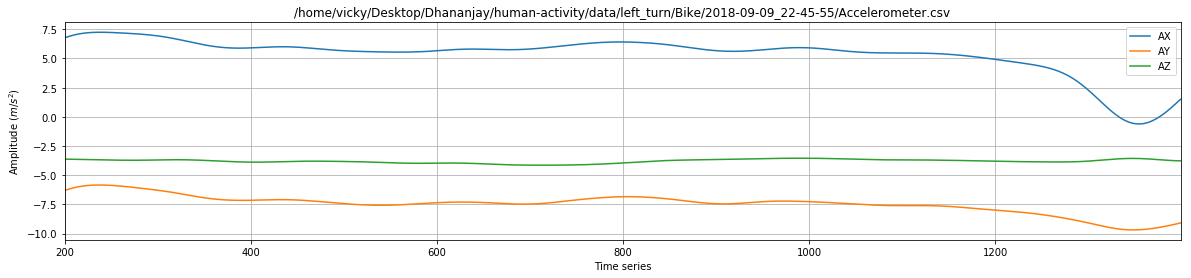

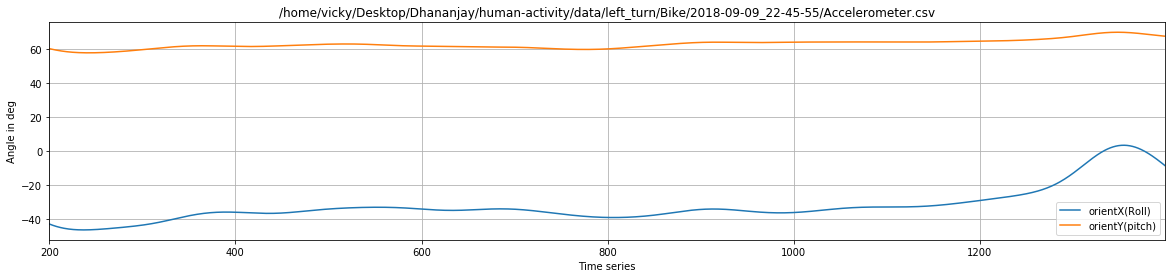

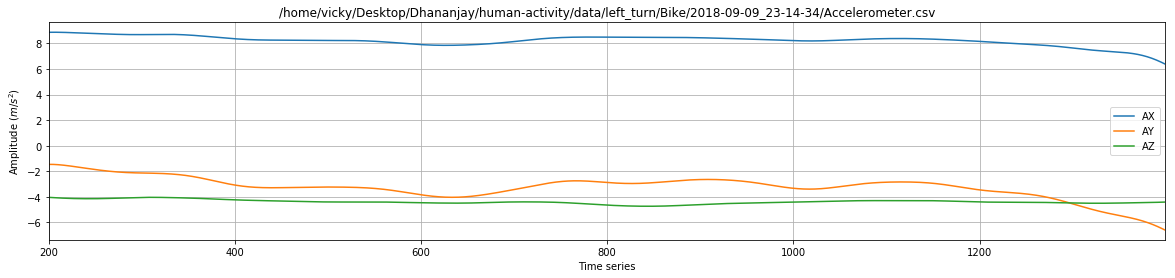

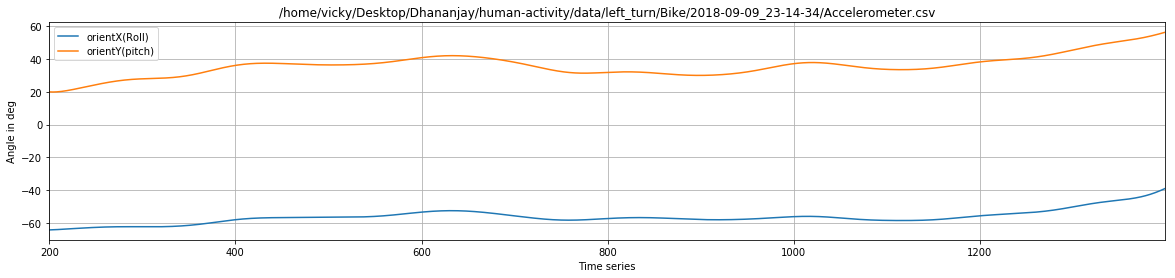

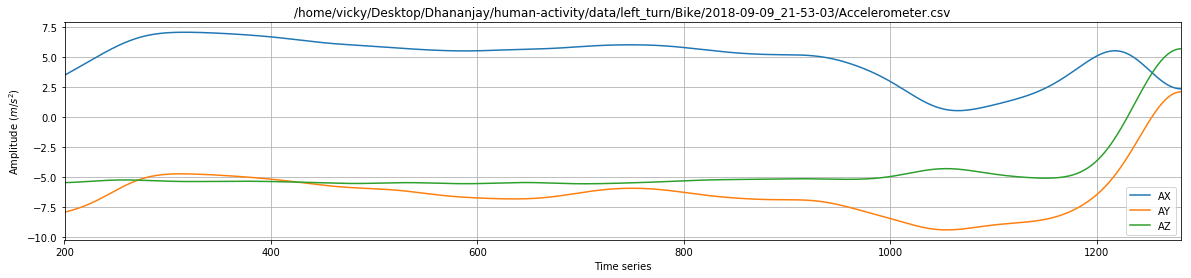

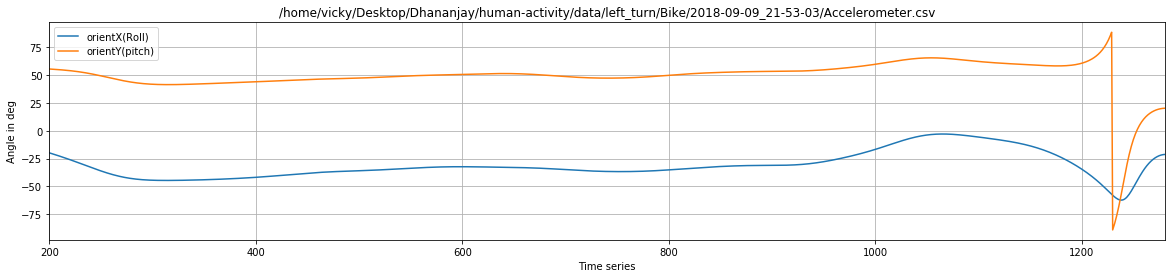

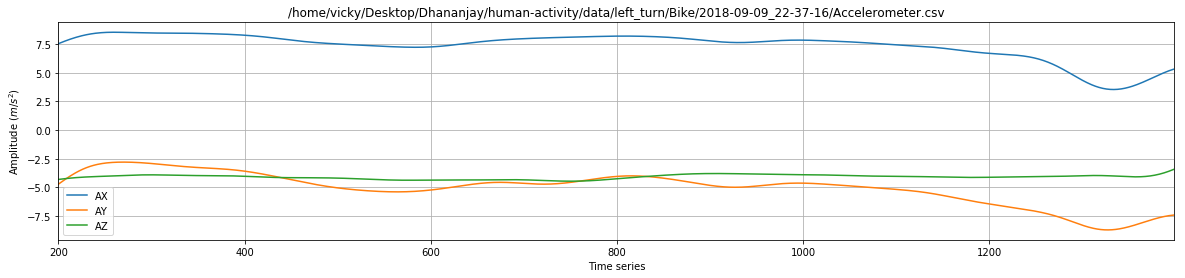

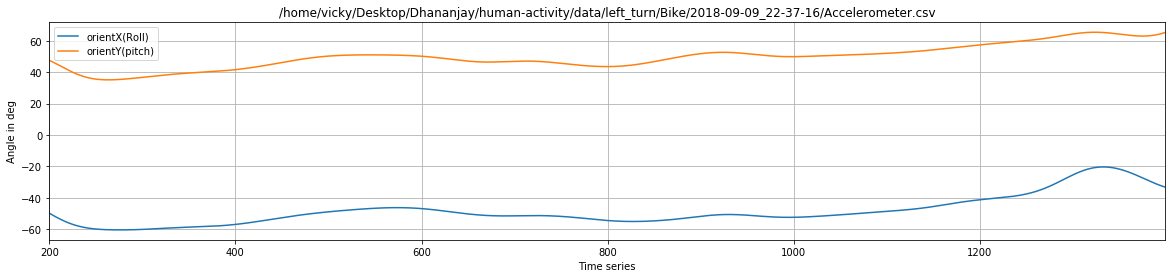

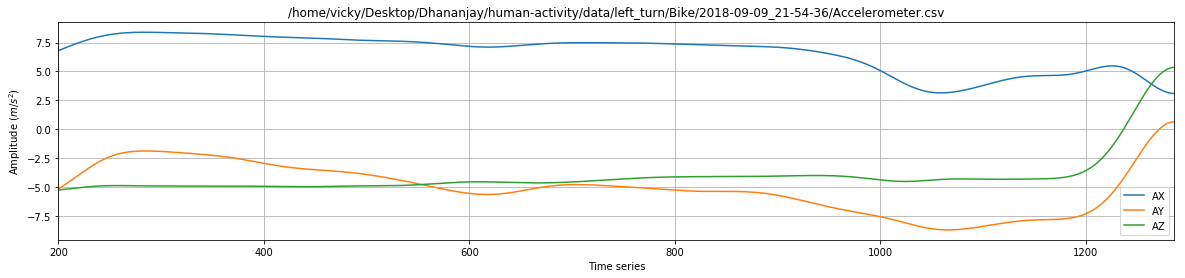

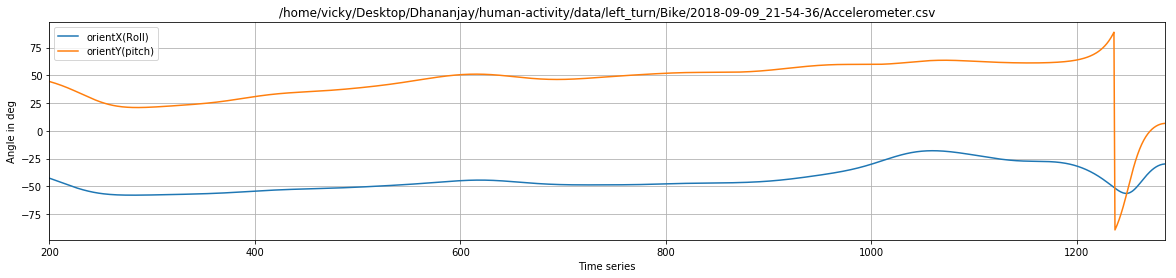

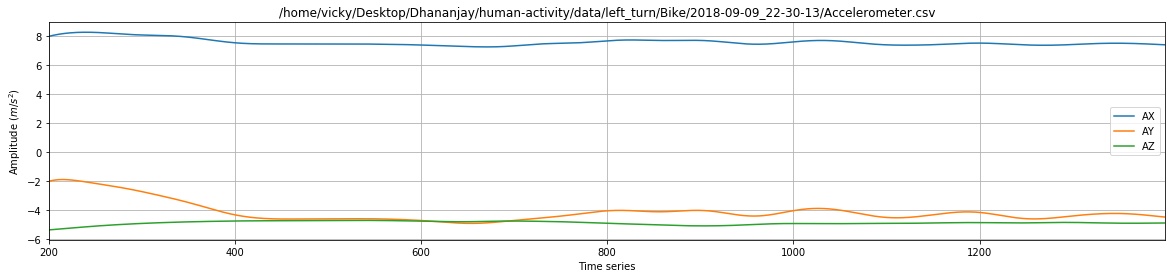

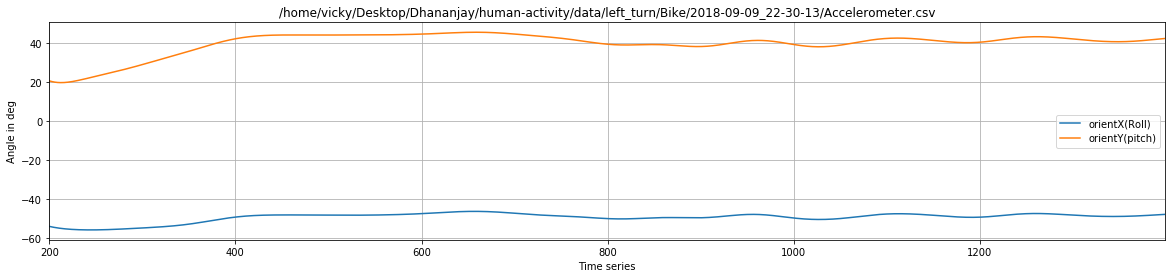

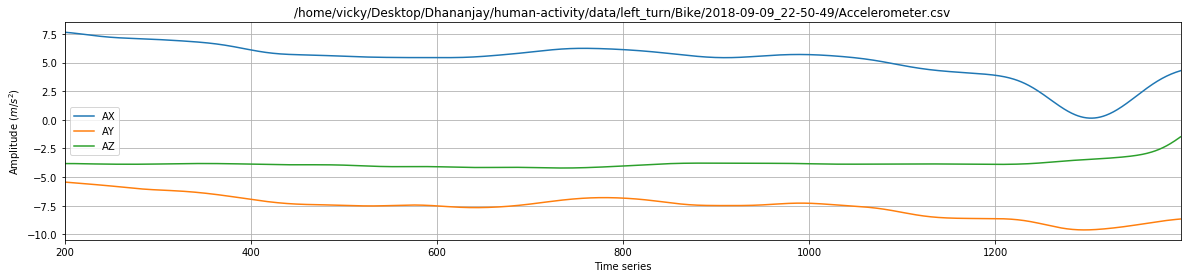

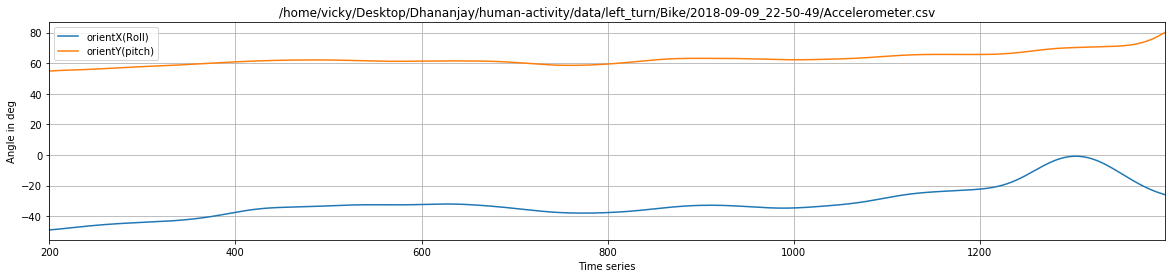

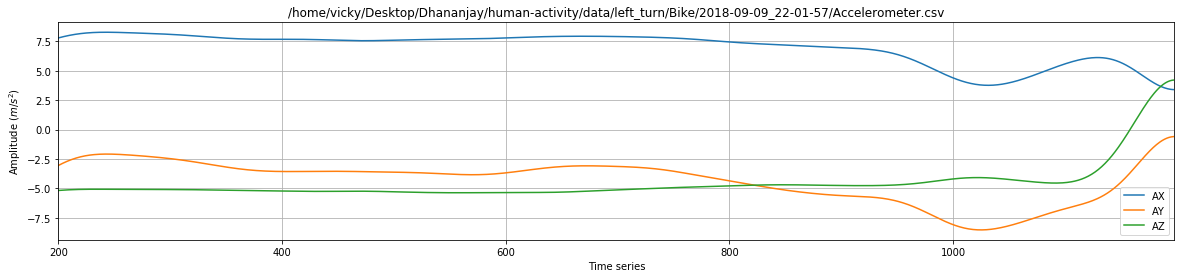

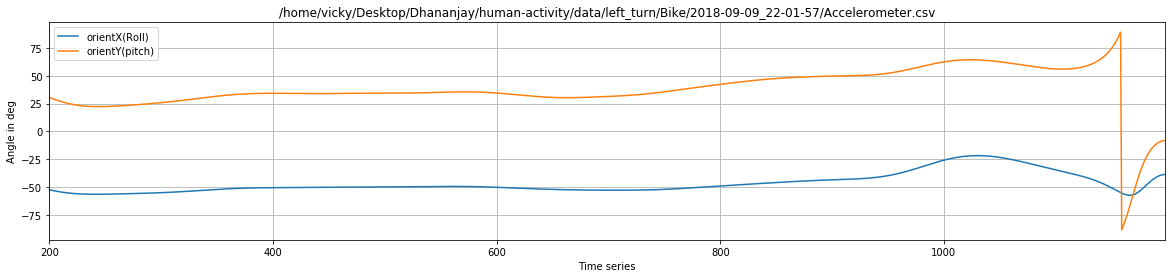

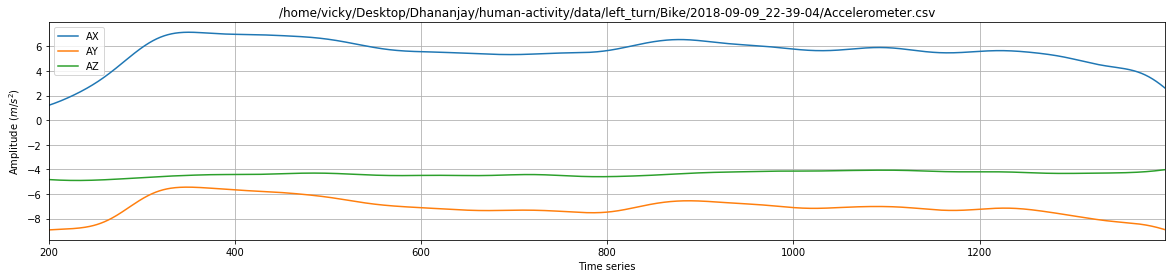

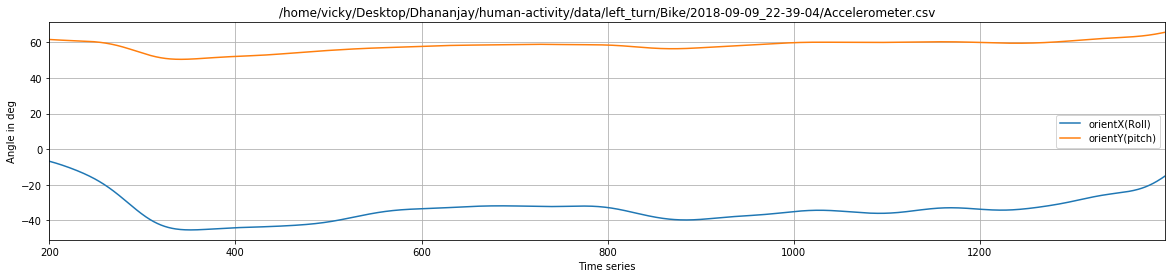

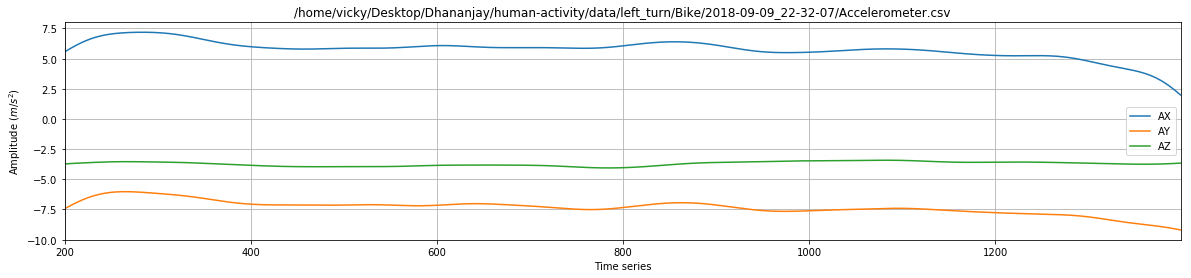

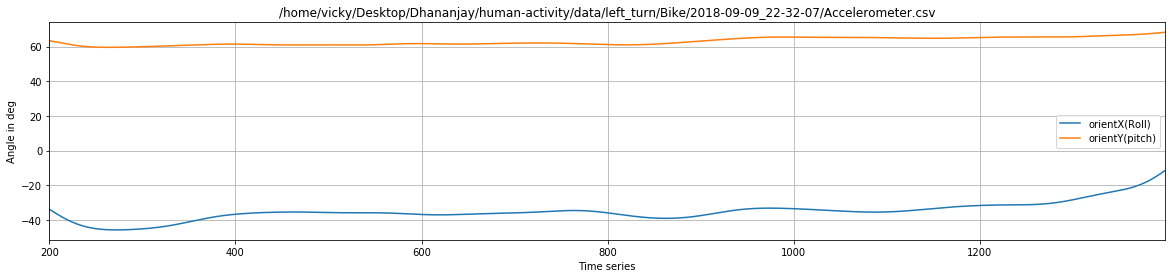

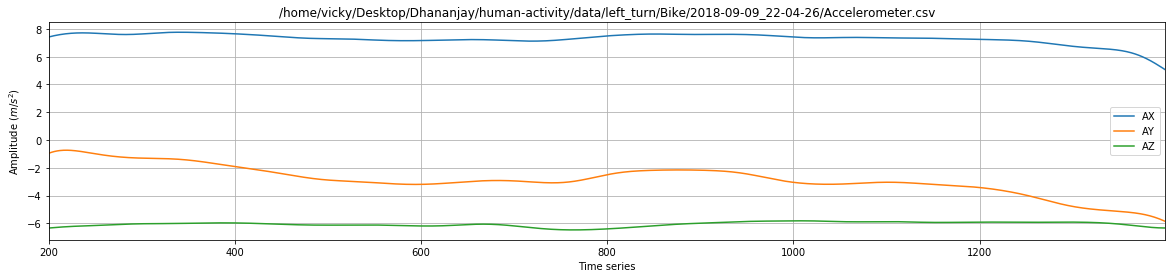

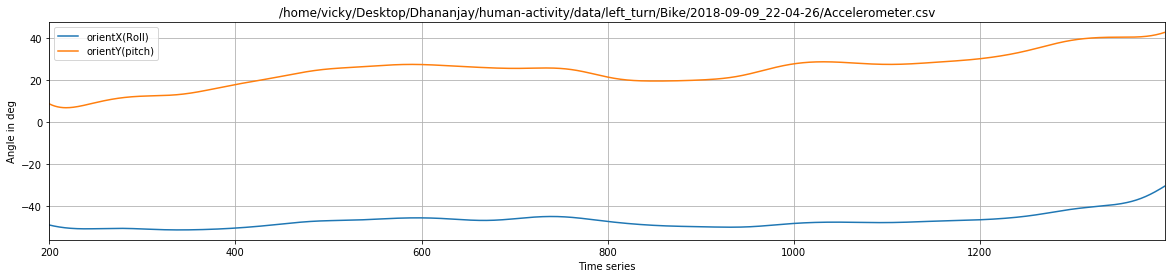

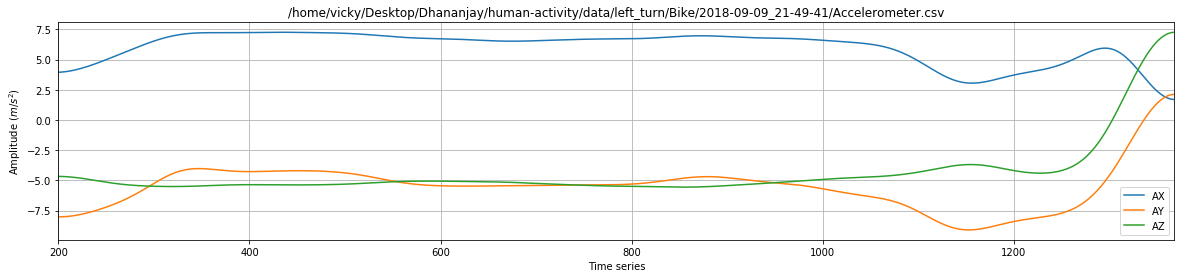

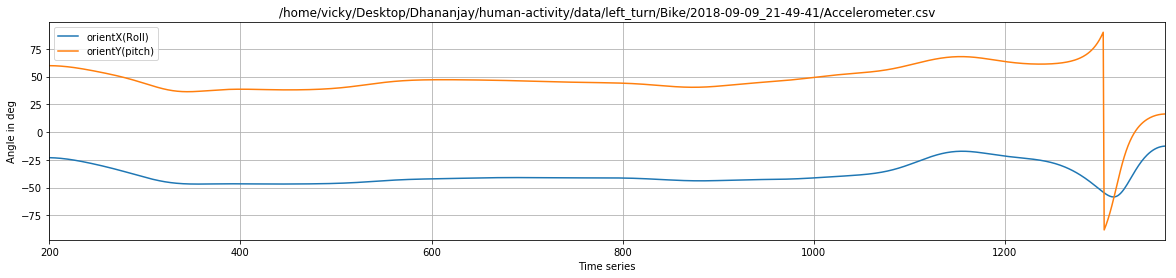

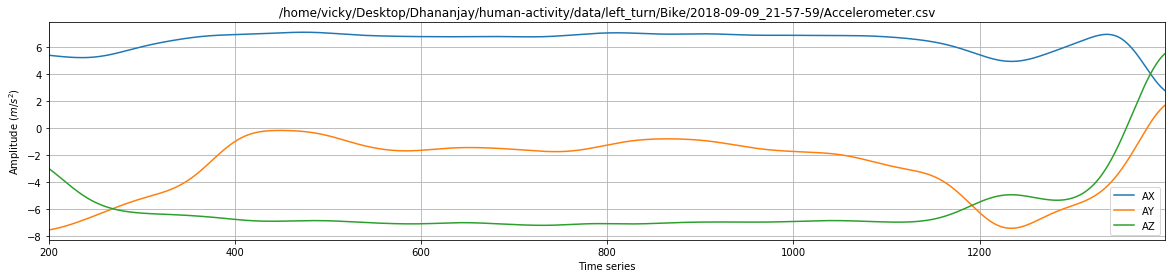

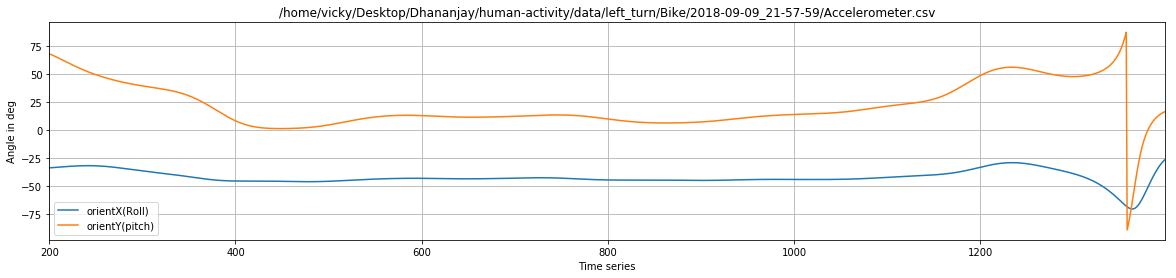

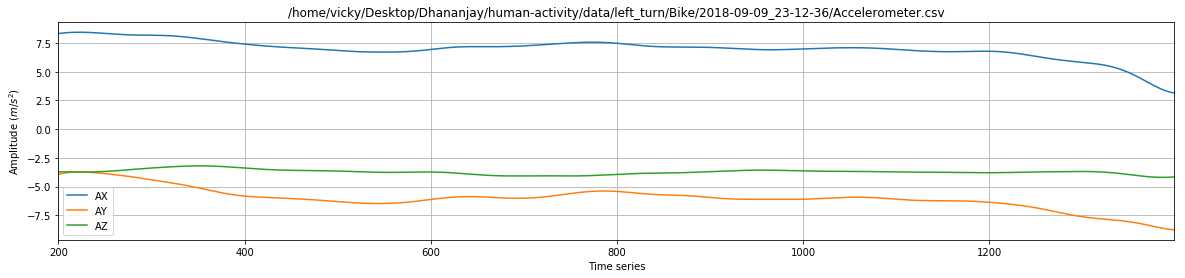

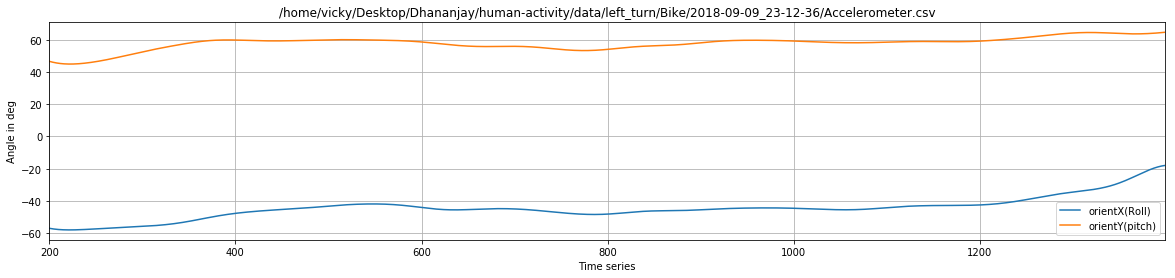

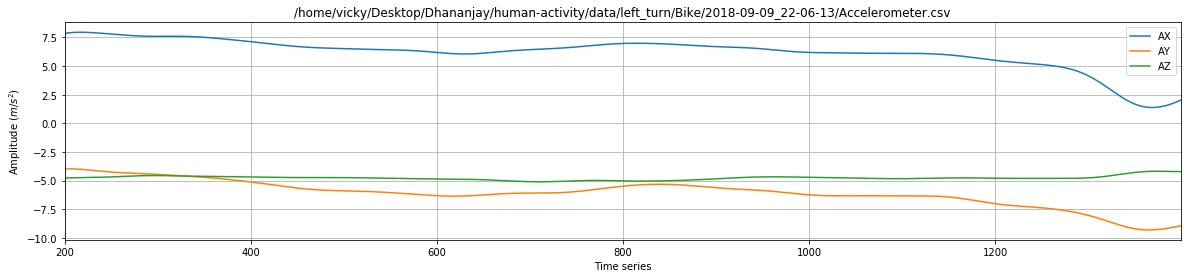

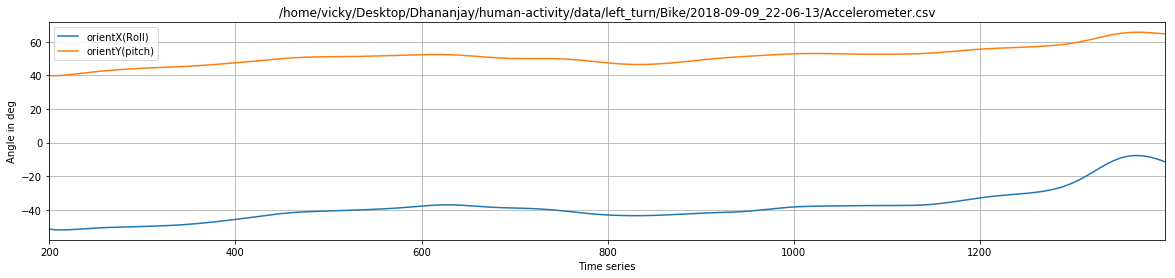

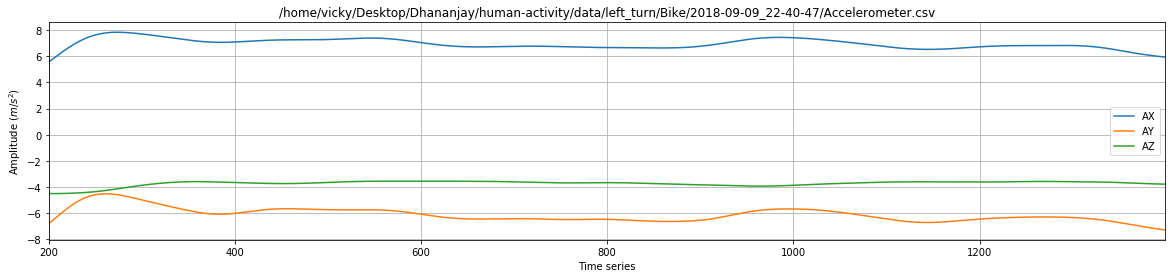

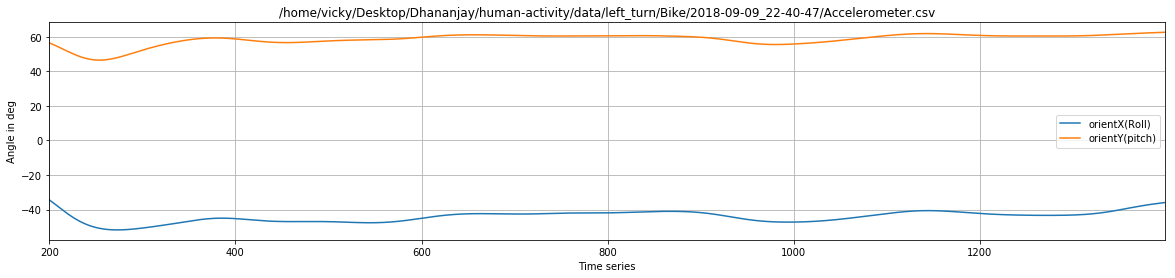

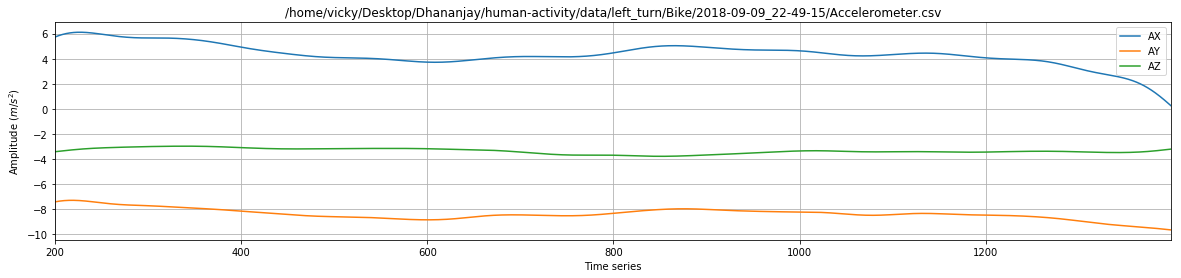

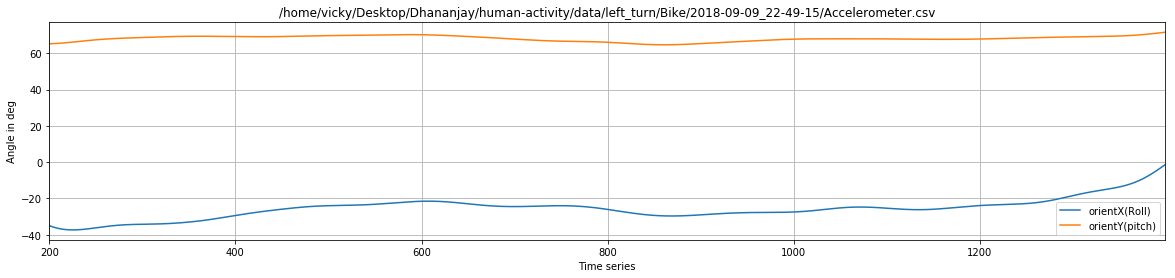

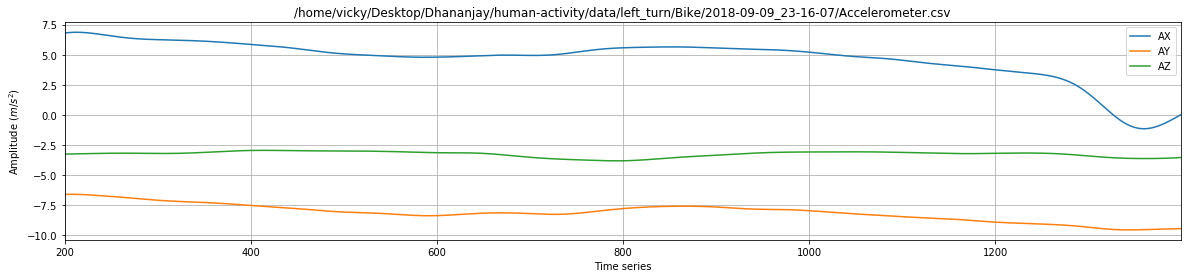

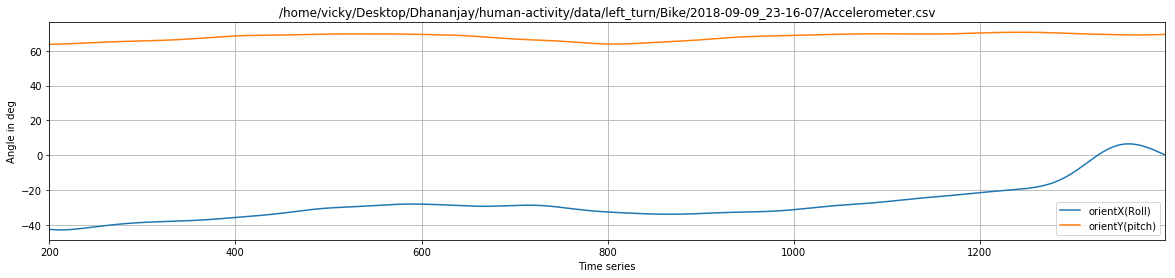

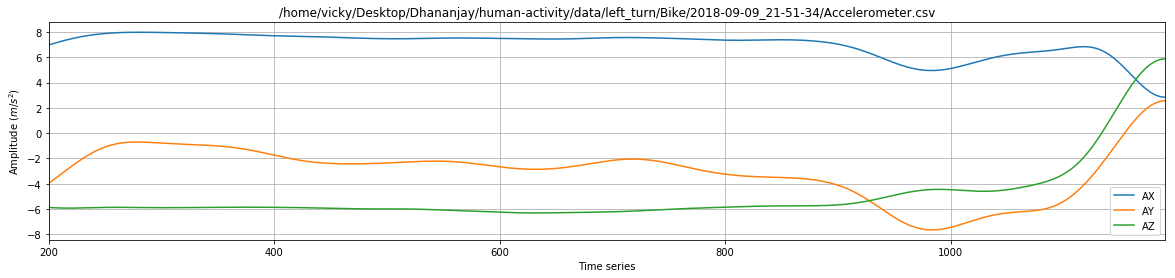

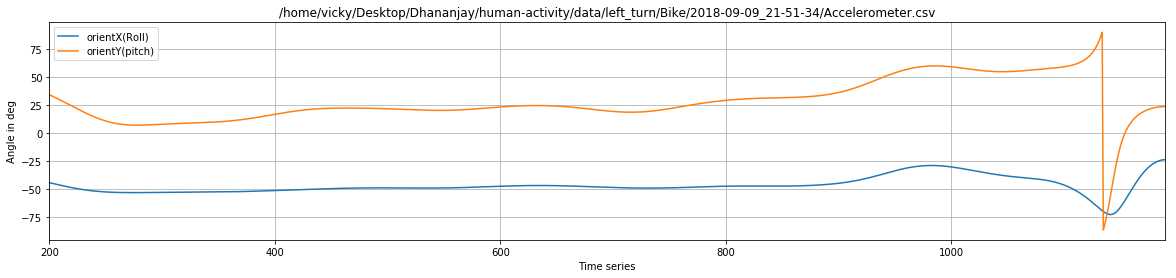

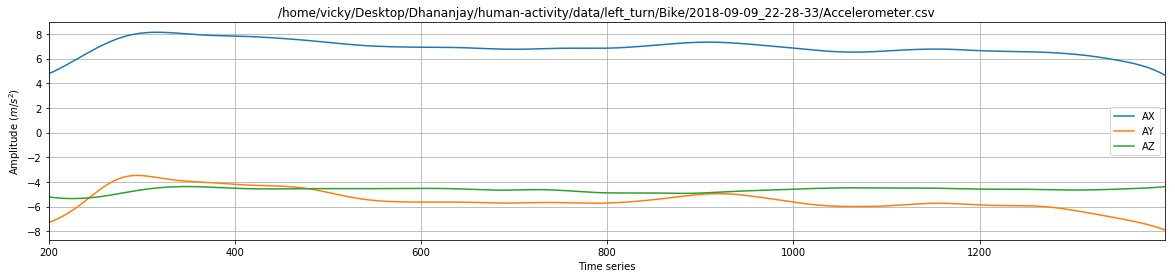

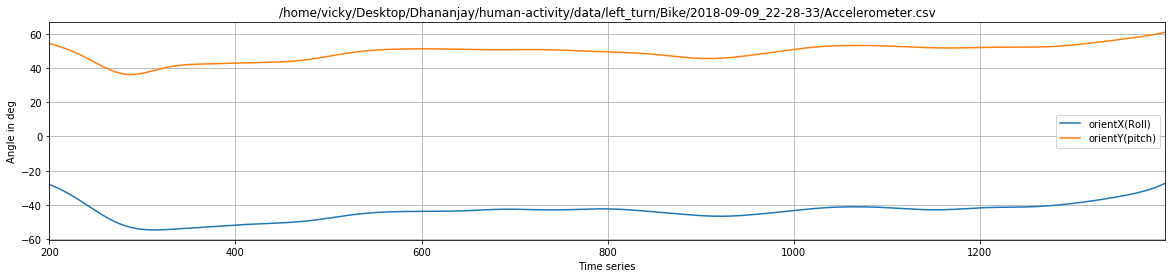

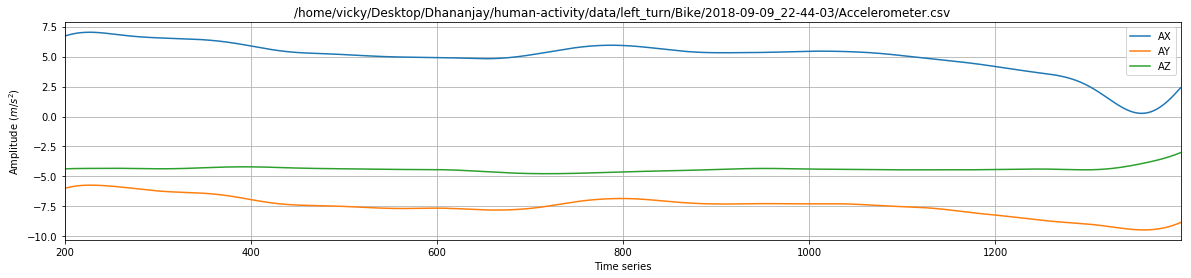

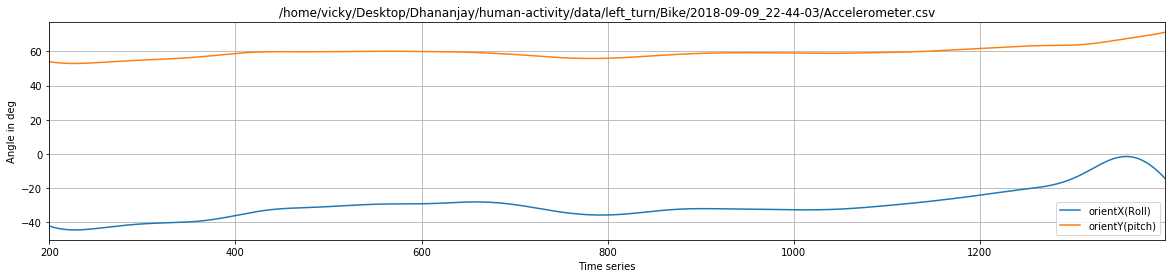

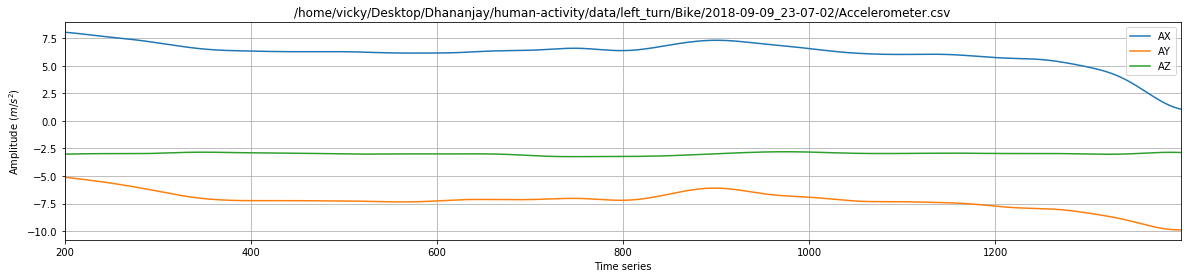

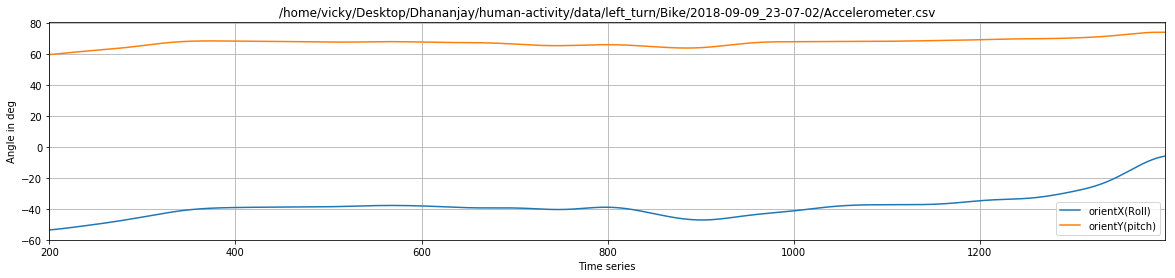

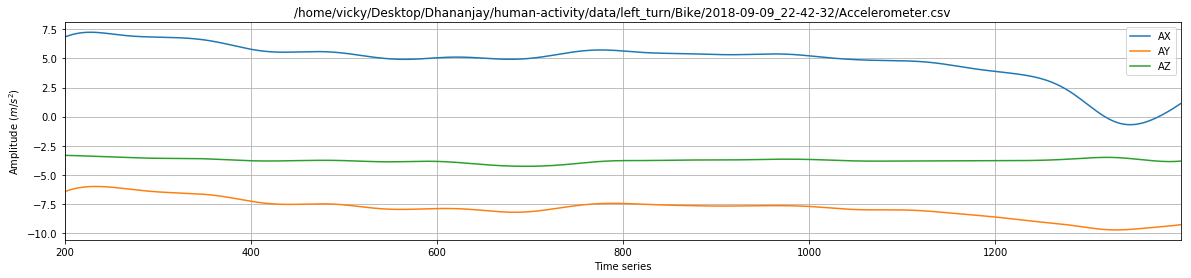

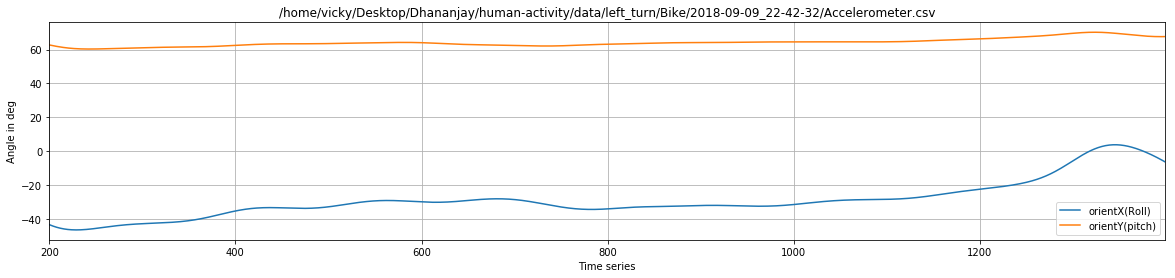

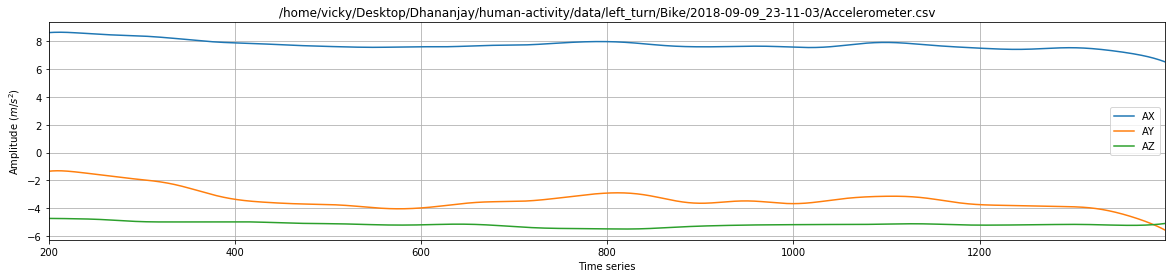

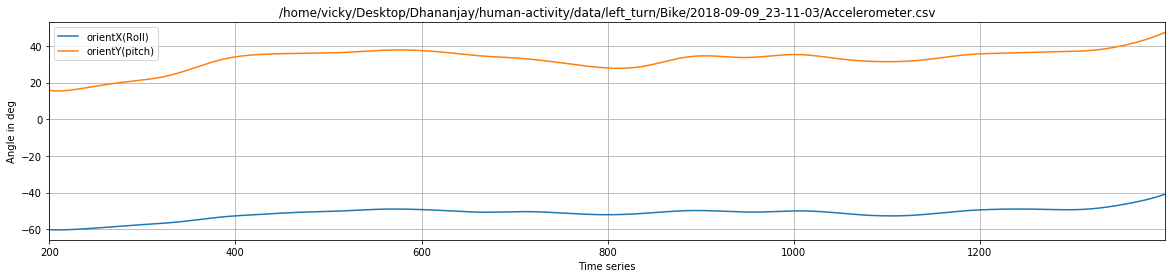

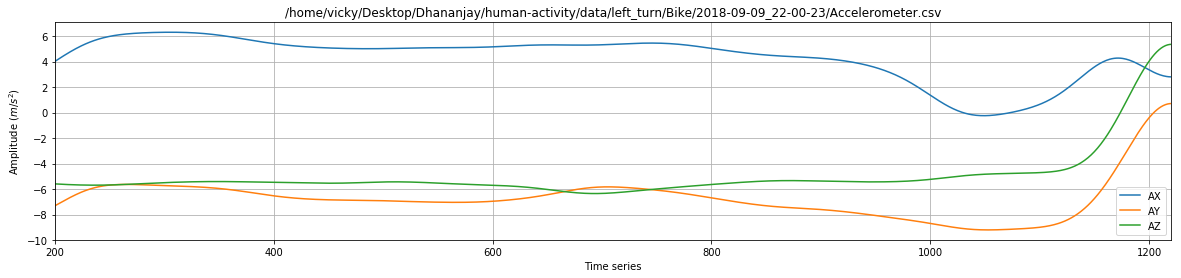

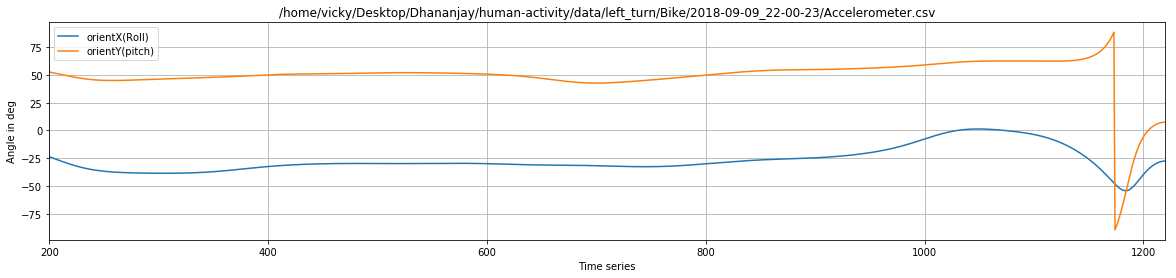

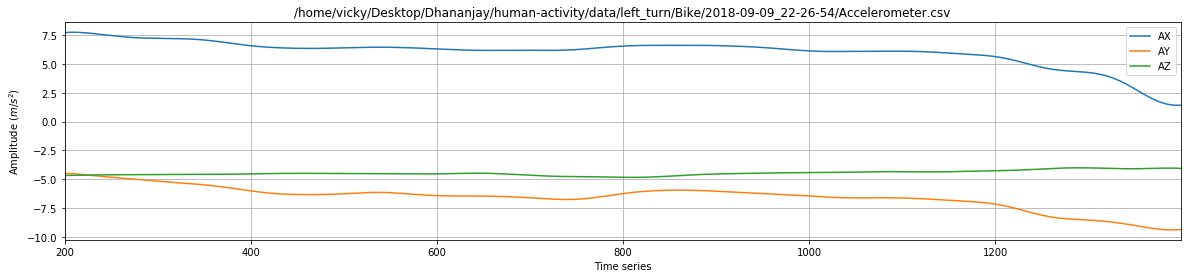

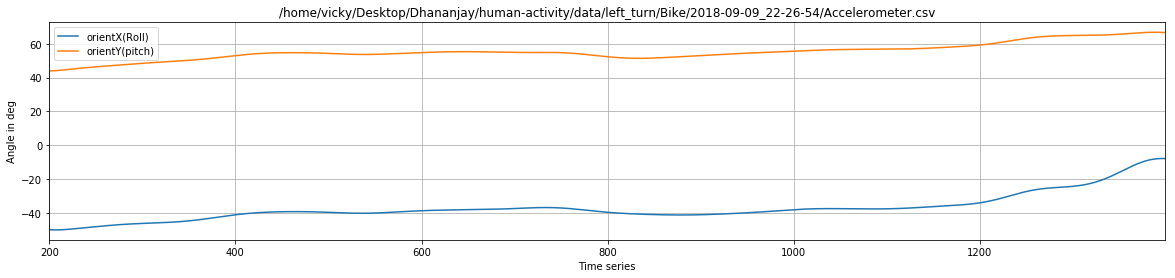

In [26]:
 
path_acc = os.getcwd() + '/data/left_turn/Bike/*/*Accelerometer.csv'
path_gyro= os.getcwd() + '/data/left_turn/Bike/*/*Gyroscope.csv' 
acc_files = glob.glob(path_acc)
gyro_files= glob.glob(path_gyro)

bike_df = []
bike_df = pd.Series(bike_df)
for acc_file, gyro_file in zip(acc_files, gyro_files) :
#     print(acc_file)
#     print(gyro_file)
    df_this = read_files(acc_file, gyro_file, 'bike')
    n = len(df_this)
    df_this = df_this[200:1400]
#     print("len of this file ",df_this.shape)
    
    fig, ax = plt.subplots()
    df_this[['AX','AY','AZ']].plot(figsize = (20,4),ax=ax, title = acc_file)
    plt.xlabel('Time series')
    plt.ylabel('Amplitude ($m/s^2$)')
    plt.grid('True')
    
#     fig, ax = plt.subplots()
#     df_this[['mAcc']].plot(figsize = (20,4),ax=ax, title = acc_file)
#     plt.xlabel('Time series')
#     plt.ylabel('Amplitude ($m/s^2$)')
#     plt.grid('True')
    
    fig, ax = plt.subplots()
    df_this[['orientX(Roll)','orientY(pitch)']].plot(figsize = (20,4),ax=ax, title = acc_file)
    plt.xlabel('Time series')
    plt.ylabel('Angle in deg')
    plt.grid('True')



In [98]:
# 2019-01-28_16-27-13 --(-x)
# 2019-01-28_16-27-51   (+x)

# 2019-01-28_16-29-01   (+y)
# 2019-01-28_16-29-46   (-y)

# 2019-01-28_16-30-36   (+x, +y)
# 2019-01-28_16-31-26   (-x, +y)
# 2019-01-28_16-32-04   (+x, -y)
# 2019-01-28_16-32-48   (-x, -x)
# 2019-01-28_16-33-22   (+x, +y)